<strong>Problem Statement (Hypothesis):</strong><br> What’s the best allocation of assets within a portfolio? This project aims to answer that question by creating models that optimize portfolios based on annual return or risk.

Investing is an excellent way to increase capital, and it has been shown that a diversified portfolio can provide the best risk-adjusted returns. However, it isn’t always easy to determine the best mix of stocks and other assets to maximize returns and/or minimize risk in a diversified portfolio.

Having  data-driven methods for optimizing the allocation of stocks or other assets in a portfolio can be applied in  use cases, for a broad section of investors, from individuals to portfolio managers, to fund managers.

This project will use the PyPortfolioOpt library to look at diversification in stock portfolios to either maximize annual return or minimize risk based on a covariance matrix. We will look at this through three different optimizers:

Efficient Frontier
Black-Litterman
Hierarchical Risk Parity

The Efficient Frontier optimizer uses the work of Harry Markowitz and its key insight is that by combining assets with different expected returns and volatilities, one can decide on a mathematically optimal allocation which minimizes the risk for a target return.

Black-Litterman asset allocation combines a prior estimate of returns (e.g the market-implied returns) with your own views to form a posterior estimate. This results in much better estimates of expected returns than just using the mean historical return.

Hierarchical Risk Parity uses clustering algorithms to choose uncorrelated assets. It is a portfolio diversification technique that uses machine learning (single linkage clustering) to allocate weights to asset classes based on their risk contributions. The algorithm was introduced in 2016 by Marcos López de Prado in his paper, Building Diversified Portfolios that Perform Well Out-Of-Sample.

These optimizers wa randomly generatedfstock erent theretical portfolios to determine the best allocation of capital based on the

Once we have optimized a sample portfolio of five randomly selected stocks we will then look to validate the results and determine the most effective portfolio optimization method through the use of regression models. We will model using linear regression, OLS, and Ridge on all three of the portfolio optimizations to further refine the optimizations and find the best combination of optimizer and regression model. model paramete
<br>rs.

Data sources: This project will use a csv of all S&P 500 stocks obtained from Github along with  the yfinance Python library to retrieve S&P 500 historical stock data from Yahoo Finance. Because the model will encompass the entirety of the S&P 500 it is possible (though not guaranteed) that data for all 500 stocks in the index will be used in the models. By using the same portfolios with each optimizer we will also be able to determine if one optimizer outperforms the others.

#Table of Contents

[1. Sourcing and loading](#Sourcing_and_loading)

[- Import packages](#import_packages)<br>
[- Load data](#load_data)<br>

[2. Cleaning and EDA](#clean_eda)
[- Cleaning the data](#clean_data)<br>
[- Exploring the data](#explore_data)<br>
[- Visualizing the data](#visualize_data)<br>

[3. Potfolio Optimization](#portfolio_optimization)
[- Creating the Portfolio](#random_portfolio)<br>
[- Efficient Frontier](#efficient_frontier)<br>
[- Black-Litterman](#black-litterman)<br>
[- Hierarchical Risk Parity](#hierarchical_risk_parity)<br>

[4. Preprocessing and Modeling](#preprocessing)
[- Ordinary Least Squares Model](#ols)<br>

## 1. Sourcing and Loading

<a id='Sourcing_and_loading'></a>

### 1a. Import packages

<a id='import_packages'></a>

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, discrete_allocation
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

### 1b. Load data

<a id='load_data'></a>

In [2]:
# Fetch S&P 500 stock list
df_sp500 = pd.read_csv(r'C:\Users\money\Desktop\Springboard\Capstone 3\constituents.csv')
tickers = df_sp500['Symbol'].tolist()

# Download historical data for S&P 500 stocks
stock_data = yf.download(tickers, start="2019-01-01", end="2024-01-01")['Adj Close']

[*********************100%%**********************]  503 of 503 completed

4 Failed downloads:
['GEV', 'SOLV']: Exception("%ticker%: Data doesn't exist for startDate = 1546318800, endDate = 1704085200")
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2019-01-01 -> 2024-01-01)')


In [3]:
# Check the first few rows of the downloaded data
print(stock_data.head())

Ticker              A        AAL       AAPL       ABBV  ABNB        ABT  \
Date                                                                      
2019-01-02  63.278915  31.963158  37.845043  69.330467   NaN  63.287045   
2019-01-03  60.947735  29.581665  34.075405  67.046127   NaN  60.300270   
2019-01-04  63.057343  31.530161  35.530045  69.206139   NaN  62.021313   
2019-01-07  64.396317  32.425682  35.450974  70.216225   NaN  62.950111   
2019-01-08  65.340355  31.904110  36.126774  70.542564   NaN  62.194317   

Ticker           ACGL         ACN        ADBE        ADI  ...         WTW  \
Date                                                      ...               
2019-01-02  26.190001  130.096832  224.570007  77.771767  ...  139.077805   
2019-01-03  25.780001  125.655037  215.699997  73.073982  ...  136.160217   
2019-01-04  26.389999  130.540985  226.190002  74.848106  ...  139.839706   
2019-01-07  26.330000  130.994415  229.259995  75.318787  ...  140.871094   
2019-01-08  

## 2. Cleaning and EDA

<a id='clean_eda'></a>

### 2a. Cleaning the data

<a id='clean_data'></a>

In [4]:
#Cleaning up the download list to remove tickers that have been delisted or may be missing price data
# Function to check if data can be downloaded for a ticker
def check_ticker(ticker):
    try:
        data = yf.download(ticker, start="2019-01-01", end="2024-01-01", progress=False)
        if data.empty:
            raise ValueError("No data returned")
        return True
    except Exception as e:
        print(f"Failed to download {ticker}: {str(e)}")
        return False

# Filter the list by checking each ticker
clean_tickers = [ticker for ticker in tickers if check_ticker(ticker)]

# Download historical data for the clean list of S&P 500 stocks
clean_stock_data = yf.download(clean_tickers, start="2019-01-01", end="2024-01-01")['Adj Close']

# Check the first few rows of the downloaded data
print(clean_stock_data.head())


1 Failed download:
['BRK.B']: Exception('%ticker%: No timezone found, symbol may be delisted')


Failed to download BRK.B: No data returned



1 Failed download:
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2019-01-01 -> 2024-01-01)')


Failed to download BF.B: No data returned



1 Failed download:
['GEV']: Exception("%ticker%: Data doesn't exist for startDate = 1546318800, endDate = 1704085200")


Failed to download GEV: No data returned



1 Failed download:
['SOLV']: Exception("%ticker%: Data doesn't exist for startDate = 1546318800, endDate = 1704085200")


Failed to download SOLV: No data returned


[*********************100%%**********************]  499 of 499 completed


Ticker              A        AAL       AAPL       ABBV  ABNB        ABT  \
Date                                                                      
2019-01-02  63.278904  31.963156  37.845039  69.330482   NaN  63.287064   
2019-01-03  60.947735  29.581665  34.075394  67.046112   NaN  60.300262   
2019-01-04  63.057354  31.530159  35.530056  69.206154   NaN  62.021317   
2019-01-07  64.396332  32.425678  35.450977  70.216232   NaN  62.950130   
2019-01-08  65.340355  31.904110  36.126774  70.542564   NaN  62.194324   

Ticker           ACGL         ACN        ADBE        ADI  ...         WTW  \
Date                                                      ...               
2019-01-02  26.190001  130.096832  224.570007  77.771774  ...  139.077805   
2019-01-03  25.780001  125.655067  215.699997  73.073975  ...  136.160233   
2019-01-04  26.389999  130.540985  226.190002  74.848099  ...  139.839722   
2019-01-07  26.330000  130.994400  229.259995  75.318794  ...  140.871094   
2019-01-08  

In [5]:
#Removing the four tickers(Symbol) that are not able to be downloaded from yfinance.

# Symbols to be removed
symbols_to_remove = ['BRK.B', 'BF.B', 'GEV', 'SOLV']

# Filter out the rows where the 'Symbol' column is in the list of symbols to remove
df_sp500 = df_sp500[~df_sp500['Symbol'].isin(symbols_to_remove)]

# Now df_sp500 should have the rows with the specified symbols removed

In [6]:
# Symbols that should have been removed
symbols_to_remove = ['BRK.B', 'BF.B', 'GEV', 'SOLV']

# Check for Existence
for symbol in symbols_to_remove:
    if symbol in df_sp500['Symbol'].values:
        print(f"{symbol} is still in the DataFrame.")
    else:
        print(f"{symbol} has been successfully removed.")

# Count Occurrences
for symbol in symbols_to_remove:
    count = df_sp500[df_sp500['Symbol'] == symbol].shape[0]
    print(f"Occurrences of {symbol}: {count}")

BRK.B has been successfully removed.
BF.B has been successfully removed.
GEV has been successfully removed.
SOLV has been successfully removed.
Occurrences of BRK.B: 0
Occurrences of BF.B: 0
Occurrences of GEV: 0
Occurrences of SOLV: 0


### 2b. Explore the data

<a id='explore_data'></a>

In [7]:
clean_stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-01-02 to 2023-12-29
Columns: 499 entries, A to ZTS
dtypes: float64(499)
memory usage: 4.8 MB


In [8]:
clean_stock_data.describe()

Ticker,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
count,1258.000000,1258.000000,1258.000000,1258.000000,768.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,...,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000
mean,112.619419,19.214294,121.413824,104.188438,139.322220,97.875700,46.247520,251.006092,423.474094,139.510943,...,204.567298,27.807288,97.039052,59.830165,67.726845,91.171243,107.951597,126.024167,321.095039,154.375625
std,29.361185,6.886768,46.758670,32.850876,28.904823,16.350800,15.884784,61.771669,115.398594,31.868775,...,25.266112,5.553772,22.103894,6.131166,25.815748,18.096322,16.770988,16.026995,120.674836,33.022540
min,60.947735,9.040000,34.075394,50.956894,82.489998,58.399956,22.240000,125.655067,215.699997,73.073975,...,136.160233,11.533245,42.583984,41.241585,25.646791,53.968822,52.494671,75.791969,146.880005,78.435394
25%,82.176207,13.835000,75.294861,73.084236,116.497499,82.872726,34.902501,191.444256,326.987495,107.020252,...,186.656509,23.670054,81.124376,56.130878,50.157192,75.776724,93.651602,114.211626,234.247505,129.539169
50%,118.633564,16.835000,132.488823,99.651085,137.704994,101.447193,41.705000,264.063126,419.380005,146.701721,...,202.788162,29.106071,97.909634,60.598335,58.274467,90.419487,109.769787,124.762581,277.934998,158.059509
75%,134.066036,23.437500,158.011349,137.917816,162.277496,109.879173,48.155001,302.680809,504.722496,164.731918,...,225.149979,31.981937,112.609684,64.083839,93.878712,104.944363,122.358133,138.491051,394.099991,175.636532
max,176.085114,36.441425,197.857529,160.493240,216.839996,135.071182,90.000000,400.401367,688.369995,199.937866,...,258.842682,39.106033,149.413544,73.069786,118.014030,133.825958,140.204865,169.488937,614.549988,241.774719


In [9]:
# Check for missing values in the DataFrame

# Find rows with at least one missing value
rows_with_missing_data = clean_stock_data[clean_stock_data.isnull().any(axis=1)]

# Display the rows with missing data
print("Rows with missing data:")
print(rows_with_missing_data)

Rows with missing data:
Ticker               A        AAL        AAPL        ABBV        ABNB  \
Date                                                                    
2019-01-02   63.278904  31.963156   37.845039   69.330482         NaN   
2019-01-03   60.947735  29.581665   34.075394   67.046112         NaN   
2019-01-04   63.057354  31.530159   35.530056   69.206154         NaN   
2019-01-07   64.396332  32.425678   35.450977   70.216232         NaN   
2019-01-08   65.340355  31.904110   36.126774   70.542564         NaN   
...                ...        ...         ...         ...         ...   
2023-09-27  109.912903  12.610000  169.988846  148.788055  134.029999   
2023-09-28  111.404930  12.920000  170.248184  147.933014  136.470001   
2023-09-29  111.225883  12.810000  170.766846  144.833450  137.210007   
2023-10-02  110.533180  12.750000  173.300247  144.046417  136.559998   
2023-10-03  109.895302  12.290000  171.953735  143.249680  127.730003   

Ticker            ABT     

In [10]:
# Calculate the percentage of missing data for each column
missing_percentage = clean_stock_data.isnull().mean() * 100

# Filter to show only columns with missing data
missing_percentage = missing_percentage[missing_percentage > 0]

# Display the percentage of missing data for columns that have it
print("Percentage of missing data in columns with missing data:")
print(missing_percentage)

Percentage of missing data in columns with missing data:
Ticker
ABNB    38.950715
CARR    24.244833
CEG     61.049285
CTVA     7.869634
DOW      4.213037
FOX      3.815580
FOXA     3.736089
GEHC    79.252782
KVUE    86.804452
OTIS    24.244833
UBER     7.074722
VLTO    95.151033
dtype: float64


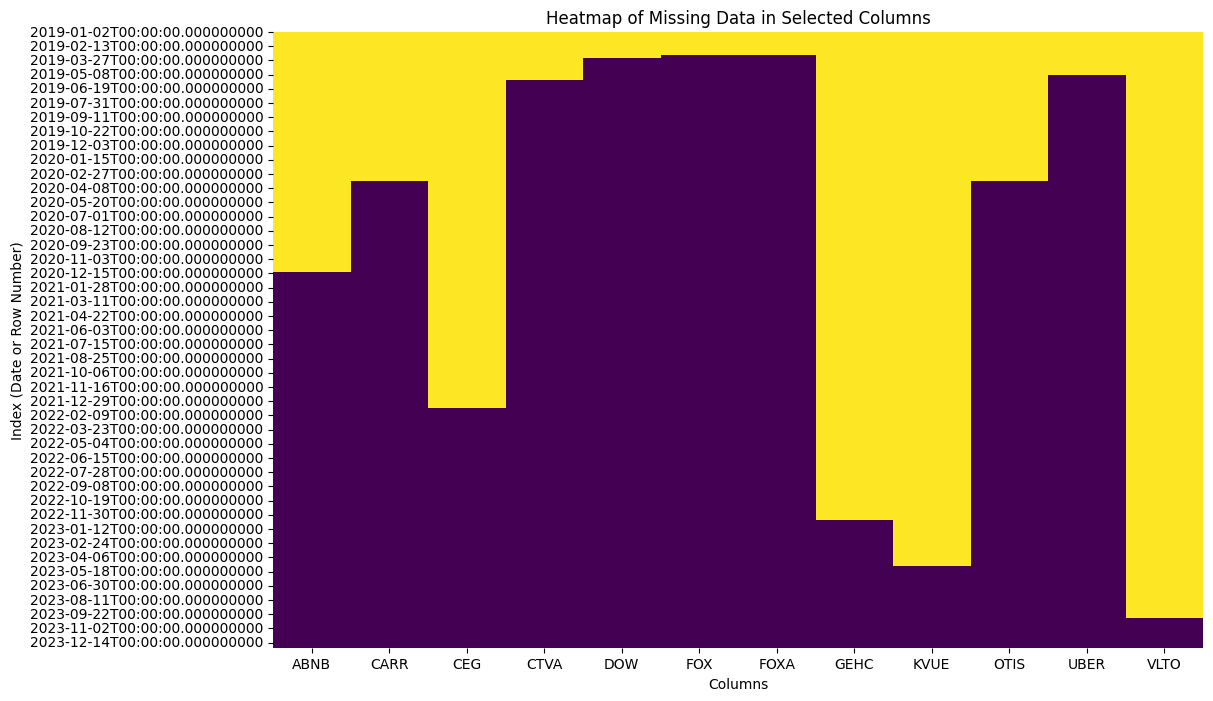

In [11]:
import seaborn as sns

# List of columns with missing data
columns_with_missing_data = ['ABNB', 'CARR', 'CEG', 'CTVA', 'DOW', 'FOX', 'FOXA', 'GEHC', 'KVUE', 'OTIS', 'UBER', 'VLTO']

# Filter the DataFrame to include only these columns
filtered_data = stock_data[columns_with_missing_data]

# Generate a heatmap to visualize where the missing data is
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_data.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Data in Selected Columns')
plt.xlabel('Columns')
plt.ylabel('Index (Date or Row Number)')
plt.show()

In [12]:
#Examining the list of S&P 500 tickers to see what features we have
df_sp500.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [13]:
df_sp500.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 499 entries, 0 to 502
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Symbol                 499 non-null    object
 1   Security               499 non-null    object
 2   GICS Sector            499 non-null    object
 3   GICS Sub-Industry      499 non-null    object
 4   Headquarters Location  499 non-null    object
 5   Date added             499 non-null    object
 6   CIK                    499 non-null    int64 
 7   Founded                499 non-null    object
dtypes: int64(1), object(7)
memory usage: 35.1+ KB


### 2c. Visualize the data

<a id='visualize_data'></a>

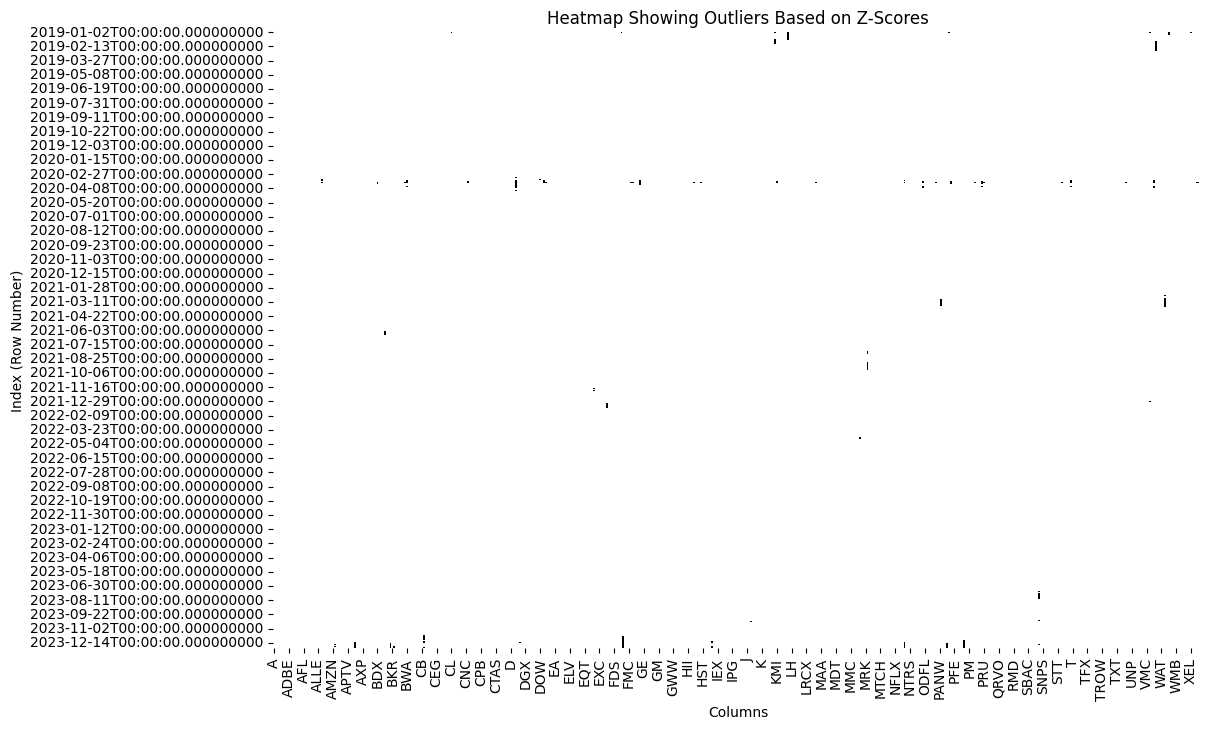

In [14]:
# Calculation of Z-scores to identify potential outliers

import seaborn as sns

# Calculate Z-scores for the entire DataFrame
z_scores = (stock_data - stock_data.mean()) / stock_data.std()

# Define a threshold for identifying outliers
threshold = 3

# Create a boolean mask where True indicates an outlier
outlier_mask = (z_scores.abs() > threshold)

# Plotting the heatmap of the outlier mask
plt.figure(figsize=(12, 8))
sns.heatmap(outlier_mask, cmap='binary', cbar=False)
plt.title('Heatmap Showing Outliers Based on Z-Scores')
plt.xlabel('Columns')
plt.ylabel('Index (Row Number)')
plt.show()

In [15]:
# Looking at the GICS sector and sub-industry features for possible segmentation later

# Count the occurrences of each 'GICS Sector'
sector_counts = df_sp500['GICS Sector'].value_counts()

# Count the occurrences of each 'GICS Sub-industry'
sub_industry_counts = df_sp500['GICS Sub-Industry'].value_counts()

# Display the results
print("GICS Sector Counts:")
print(sector_counts)
print("\nGICS Sub-Industry Counts:")
print(sub_industry_counts)

GICS Sector Counts:
Industrials               78
Financials                70
Information Technology    65
Health Care               63
Consumer Discretionary    52
Consumer Staples          37
Real Estate               31
Utilities                 30
Materials                 28
Energy                    23
Communication Services    22
Name: GICS Sector, dtype: int64

GICS Sub-Industry Counts:
Health Care Equipment                           18
Semiconductors                                  15
Industrial Machinery & Supplies & Components    14
Electric Utilities                              14
Aerospace & Defense                             12
                                                ..
Agricultural & Farm Machinery                    1
Consumer Electronics                             1
Copper                                           1
Commodity Chemicals                              1
Timber REITs                                     1
Name: GICS Sub-Industry, Length: 124, dty

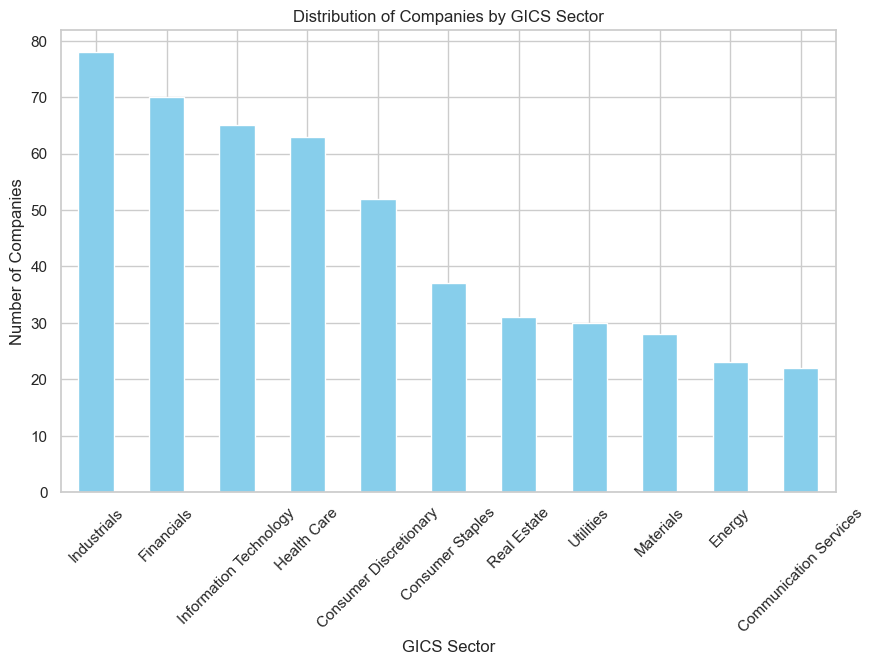

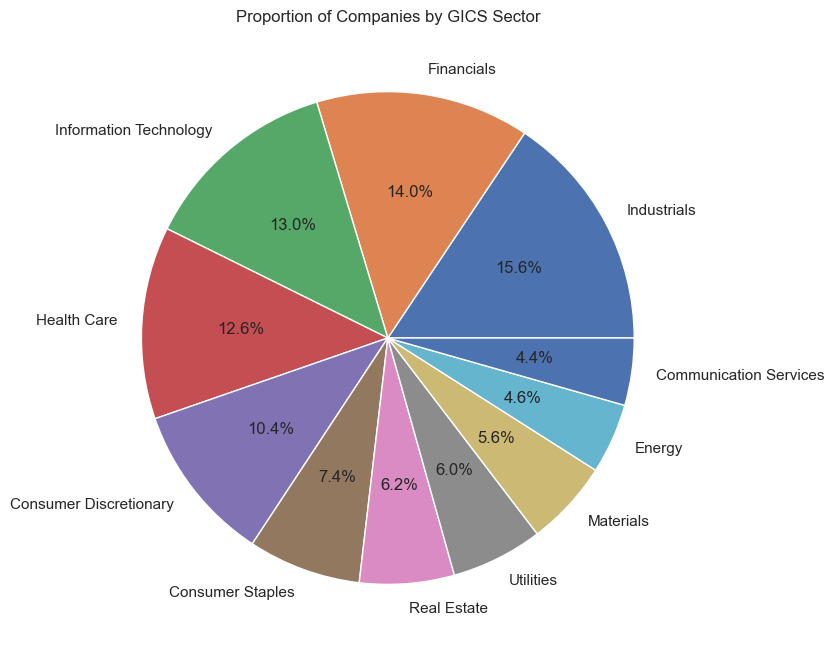

In [16]:
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a bar chart for GICS Sector
plt.figure(figsize=(10, 6))
sector_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Companies by GICS Sector')
plt.xlabel('GICS Sector')
plt.ylabel('Number of Companies')
plt.xticks(rotation=45)
plt.show()

# Create a pie chart for GICS Sector
plt.figure(figsize=(8, 8))
sector_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Proportion of Companies by GICS Sector')
plt.ylabel('')  # Hide the y-label
plt.show()

C:\Users\money\AppData\Local\Temp\ipykernel_7932\3797876563.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1400x700 with 0 Axes>

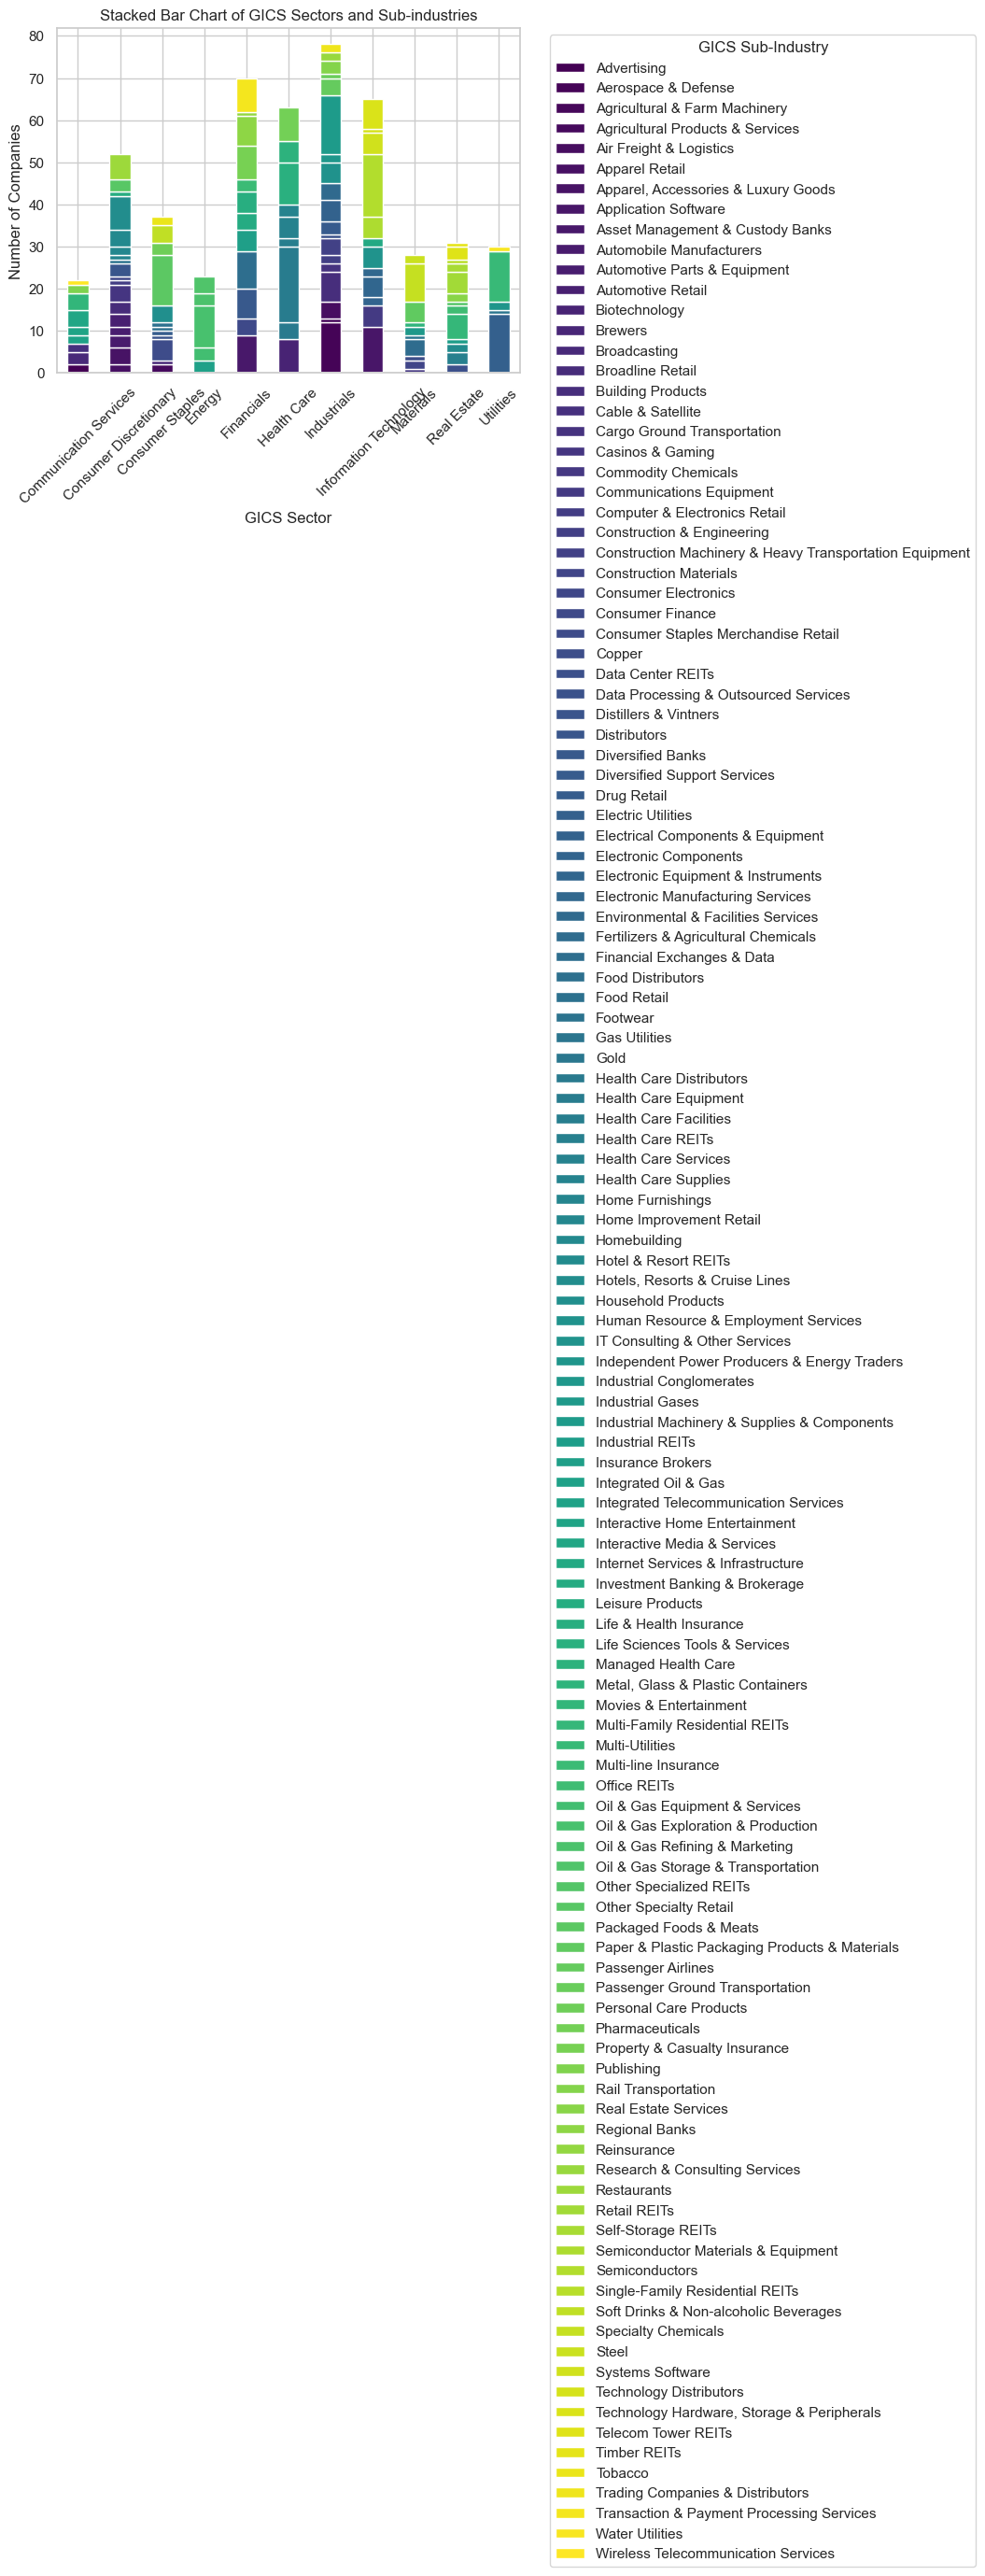

In [17]:
#Visualizing the industry data

# Prepare data for stacked bar chart
pivot_df = df_sp500.groupby(['GICS Sector', 'GICS Sub-Industry']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(14, 7))
pivot_df.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Stacked Bar Chart of GICS Sectors and Sub-industries')
plt.xlabel('GICS Sector')
plt.ylabel('Number of Companies')
plt.xticks(rotation=45)
plt.legend(title='GICS Sub-Industry', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

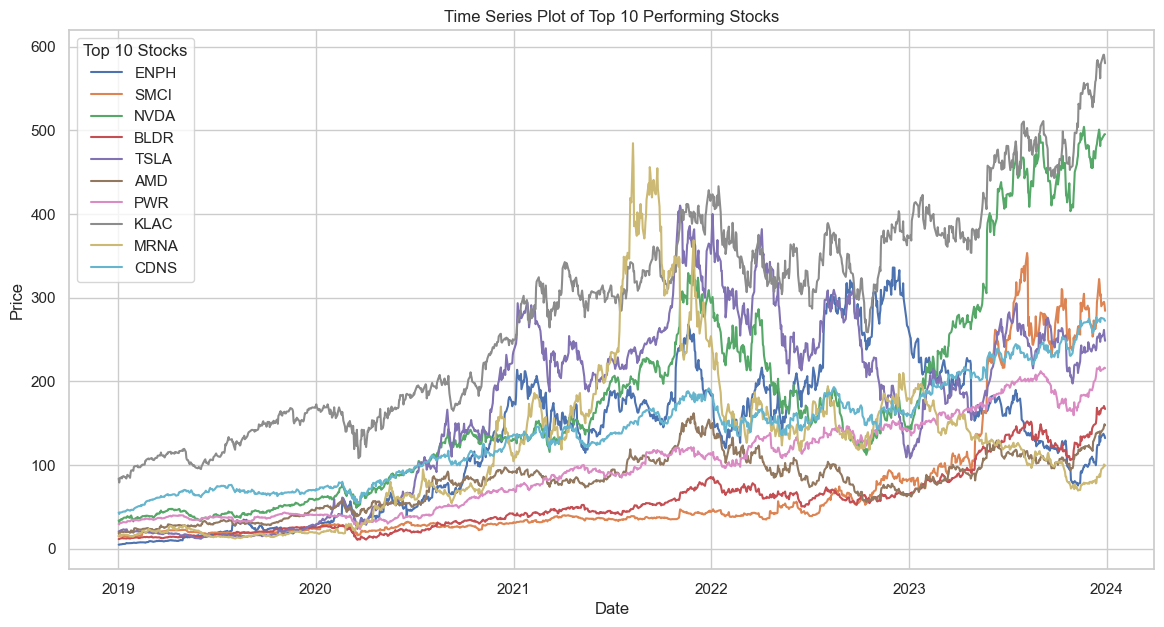

In [18]:
# Plot returns for top 10 best performing stocks

# Calculate daily returns
daily_returns = clean_stock_data.pct_change()

# Calculate cumulative returns
cumulative_returns = (1 + daily_returns).cumprod() - 1

# Find the final cumulative return for each stock to determine the top 10
final_returns = cumulative_returns.iloc[-1].sort_values(ascending=False)

# Get the names of the top 10 performing stocks
top_10_stocks = final_returns.head(10).index

# Plot the stock data for the top 10 stocks
plt.figure(figsize=(14, 7))
for column in top_10_stocks:
    plt.plot(clean_stock_data.index, clean_stock_data[column], label=column)

plt.title('Time Series Plot of Top 10 Performing Stocks')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(title='Top 10 Stocks')
plt.show()

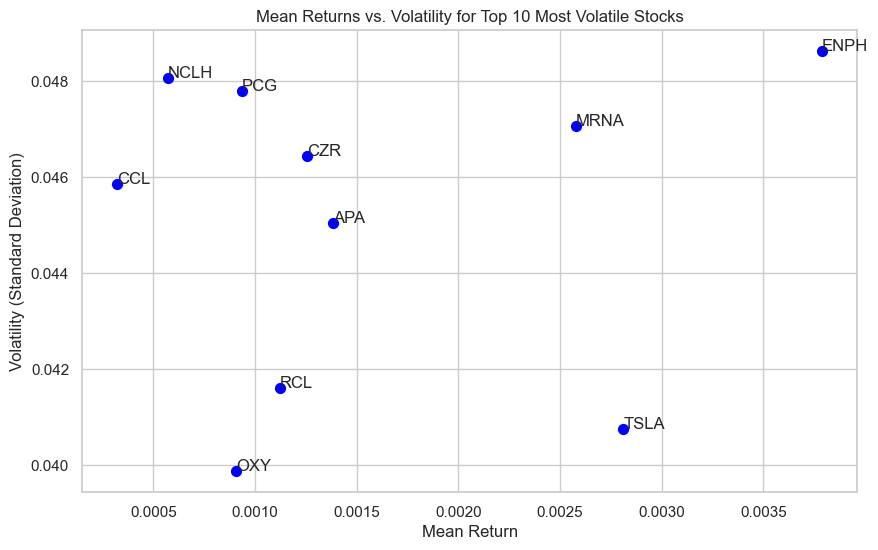

In [19]:
# Top ten most volatile stocks

# Calculate daily returns
daily_returns = clean_stock_data.pct_change()

# Calculate mean and standard deviation (volatility) of daily returns for each stock
means = daily_returns.mean()
volatilities = daily_returns.std()

# Combine the means and volatilities into a DataFrame
volatility_data = pd.DataFrame({
    'Mean Return': means,
    'Volatility': volatilities
})

# Sort the stocks by volatility (standard deviation)
top_10_volatile_stocks = volatility_data.sort_values(by='Volatility', ascending=False).head(10)

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(top_10_volatile_stocks['Mean Return'], top_10_volatile_stocks['Volatility'], color='blue', s=50)
plt.title('Mean Returns vs. Volatility for Top 10 Most Volatile Stocks')
plt.xlabel('Mean Return')
plt.ylabel('Volatility (Standard Deviation)')
plt.grid(True)

# Annotate stock names on the plot
for i in top_10_volatile_stocks.index:
    plt.annotate(i, (top_10_volatile_stocks.loc[i, 'Mean Return'], top_10_volatile_stocks.loc[i, 'Volatility']))

plt.show()

## 3. Portfolio Optimization

<a id='portfolio_optimization'></a>

Below we explore the three different portfolio optimization methods - Efficient Frontier, Black-Litterman, and Hierarchical Risk Parity - on a portfolio of the ten best performing stocks from 1/1/19 through 1/1/23 in the df_sp500 dataset. We ensure diversity by limiting the selection to include no more than two stocks from any specific GICS Sector.

### 3a. Creating the portfolio

<a id='random_portfolio'></a>

In [20]:
# Display the first few rows of each dataframe to understand their structure
clean_stock_data.head(), df_sp500.head()

# Calculate the annual returns for each stock
annual_returns = clean_stock_data.pct_change().mean() * 252  # Converting daily returns to annual

# Create a dataframe of returns
returns_df = pd.DataFrame(annual_returns, columns=['Annual Return'])

# Merge the returns dataframe with the S&P 500 information to get sector details
merged_data = returns_df.merge(df_sp500[['Symbol', 'GICS Sector']], left_index=True, right_on='Symbol')

# Sort the data by annual return
sorted_data = merged_data.sort_values(by='Annual Return', ascending=False)

# Filter out the top stocks, ensuring no more than two stocks per GICS sector
top_stocks = pd.DataFrame()
for sector in sorted_data['GICS Sector'].unique():
    sector_stocks = sorted_data[sorted_data['GICS Sector'] == sector].head(2)
    top_stocks = pd.concat([top_stocks, sector_stocks])
    if len(top_stocks) >= 10:
        break

df_portfolio = top_stocks.head(10)
df_portfolio

# Print the selected portfolio
print("Selected Portfolio:")
print(df_portfolio[['Symbol', 'GICS Sector']])
df_portfolio.to_csv('df_portfolio.csv')

Selected Portfolio:
    Symbol             GICS Sector
171   ENPH  Information Technology
430   SMCI  Information Technology
444   TSLA  Consumer Discretionary
143   DECK  Consumer Discretionary
79    BLDR             Industrials
89    CARR             Industrials
321   MRNA             Health Care
147   DXCM             Health Care
126    CEG               Utilities
371    PCG               Utilities


### 3b. Efficient Frontier

<a id='efficient_frontier'></a>

Now we optimize asset allocation of the randomly generated portfolio using the Efficient Frontier model. We do this using the PyPortfolioOpt library,  a tool designed specifically for portfolio optimization in Python. This process involves calculating expected returns, the covariance matrix for the portfolio, and then using these to determine the weights that either maximize the Sharpe ratio or minimize volatility.

In [21]:
# Filter the clean_stock_data to include only the stocks present in df_portfolio
selected_stocks = df_portfolio['Symbol'].unique()  # Extract unique stock symbols
filtered_data = clean_stock_data[selected_stocks]

# Calculate expected returns and the covariance matrix
mu = expected_returns.mean_historical_return(filtered_data)
S = risk_models.sample_cov(filtered_data)

# Optimize for the maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
print("Optimized Portfolio Weights:", cleaned_weights)

# Display expected performance of the portfolio
ef.portfolio_performance(verbose=True)

# Calculate and display the percentage performance of each stock
# Loop through each stock in the portfolio to print its expected return
for ticker in df_portfolio['Symbol'].unique():  # or selected_stocks if defined elsewhere
    expected_return = mu[ticker]
    print(f"Expected annual return for {ticker}: {expected_return:.2%}")

Optimized Portfolio Weights: OrderedDict([('ENPH', 0.06437), ('SMCI', 0.13648), ('TSLA', 0.00334), ('DECK', 0.0), ('BLDR', 0.11624), ('CARR', 0.17905), ('MRNA', 0.03014), ('DXCM', 0.0), ('CEG', 0.47038), ('PCG', 0.0)])
Expected annual return: 69.9%
Annual volatility: 30.7%
Sharpe Ratio: 2.22
Expected annual return for ENPH: 93.42%
Expected annual return for SMCI: 80.12%
Expected annual return for TSLA: 64.62%
Expected annual return for DECK: 38.98%
Expected annual return for BLDR: 70.94%
Expected annual return for CARR: 53.46%
Expected annual return for MRNA: 45.48%
Expected annual return for DXCM: 34.03%
Expected annual return for CEG: 71.32%
Expected annual return for PCG: -5.40%


#### Visualizing the Efficient Frontier

C:\Users\money\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Expected annual return: 69.9%
Annual volatility: 30.7%
Sharpe Ratio: 2.22


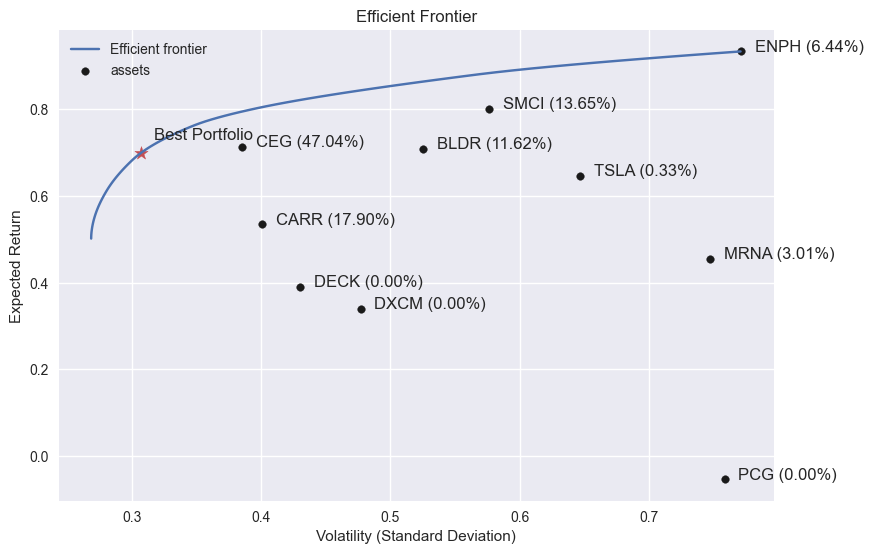

In [22]:
from pypfopt import plotting

# Create a new Efficient Frontier object for plotting
plotting_ef = EfficientFrontier(mu, S)

# Plot the Efficient Frontier
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(plotting_ef, ax=ax, show_assets=True)

# Overlay asset tickers as labels with weights
for txt in selected_stocks:
    if txt in cleaned_weights:
        ax.annotate(f"{txt} ({cleaned_weights[txt]:.2%})", (S.loc[txt, txt]**0.5, mu[txt]), 
                    xytext=(10,0), textcoords='offset points')

# Find the optimal portfolio for marking
ef_opt = EfficientFrontier(mu, S)
sharpe_pwt = ef_opt.max_sharpe()
sharpe_perf = ef_opt.portfolio_performance(verbose=True)
ax.scatter(sharpe_perf[1], sharpe_perf[0], marker="*", s=100, c='r', label='Best Portfolio')

# Annotate the 'Best Portfolio' point
ax.annotate('Best Portfolio', (sharpe_perf[1], sharpe_perf[0]), xytext=(10,10), textcoords='offset points')

plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.show()

### 3c. Black-Litterman

Now we want to look at potentially improving the performance of our optimization. We will do this using Black-Litterman asset allocation, which combines a prior estimate of returns (e.g the market-implied returns) with the users views to form a posterior estimate. The Black-Litterman model adjusts the Capital Asset Pricing Model (CAPM) assumption that the market portfolio is the center of the efficient frontier based on the investor's views on expected returns, thus modifying the expected returns and the risk-return trade-offs. This results in much better estimates of expected returns than just using the mean historical return.

<a id='black_litterman'></a>

Optimized Portfolio Weights: OrderedDict([('ENPH', 0.0), ('SMCI', 0.03938), ('TSLA', 0.00673), ('DECK', 0.15937), ('BLDR', 0.02725), ('CARR', 0.23365), ('MRNA', 0.05365), ('DXCM', 0.13648), ('CEG', 0.27335), ('PCG', 0.07015)])
Expected annual return: 9.0%
Annual volatility: 27.1%
Sharpe Ratio: 0.26
Expected Returns for Each Stock:
ENPH: 9.65%
SMCI: 9.44%
TSLA: 9.55%
DECK: 9.21%
BLDR: 9.83%
CARR: 8.89%
MRNA: 8.70%
DXCM: 9.10%
CEG: 8.68%
PCG: 9.26%


C:\Users\money\anaconda3\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


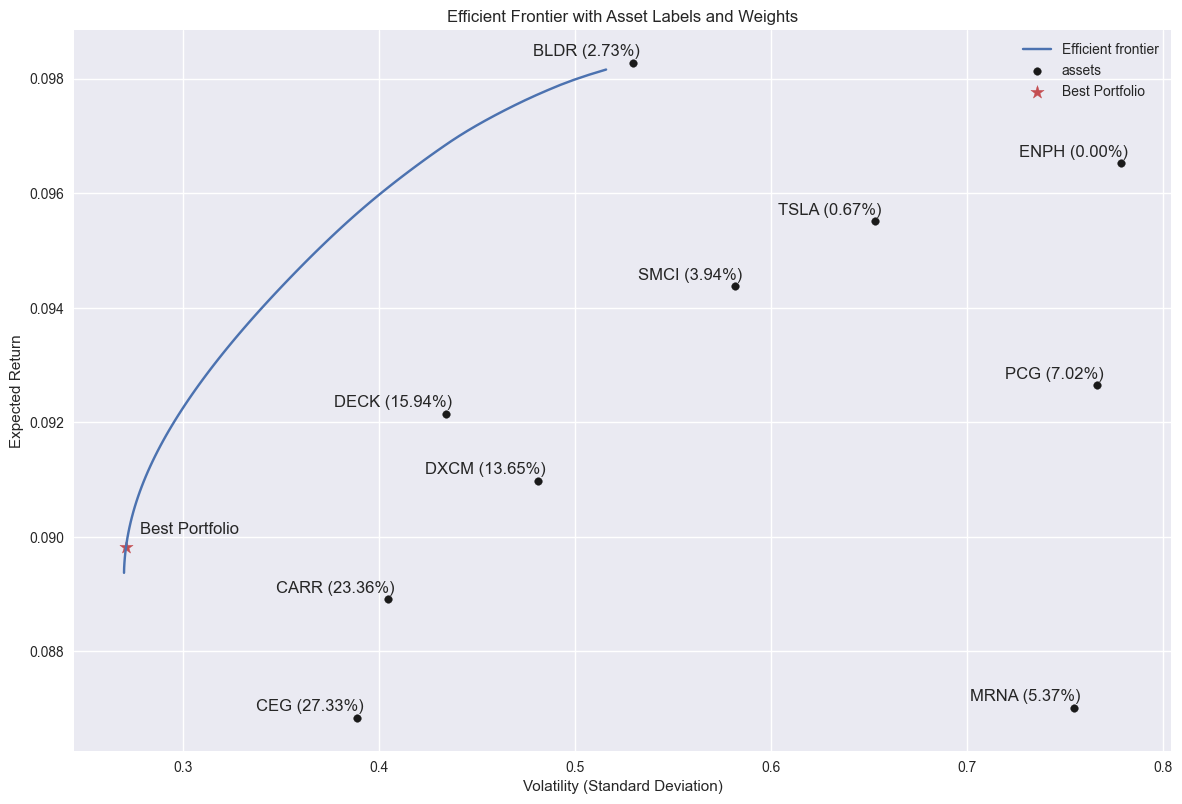

In [23]:
from pypfopt import black_litterman

# Filter clean_stock_data and df_portfolio to include only relevant stocks
portfolio_stocks = df_portfolio['Symbol'].unique()
filtered_data = clean_stock_data[portfolio_stocks]

# Calculate the prior returns and the covariance matrix for filtered stocks
mu = expected_returns.mean_historical_return(filtered_data, frequency=252)
S = risk_models.sample_cov(filtered_data)

# Market-implied risk aversion and equilibrium returns
# Risk free rate is set to the yield from 1-month Treasury bills
delta = black_litterman.market_implied_risk_aversion(mu, risk_free_rate=0.0538)
market_prior = black_litterman.market_implied_prior_returns(mu, delta, S)

# Define simple views and confidences - Adding 10.5% to expected view based on the outperformance of the EF model versus the S&P 500 over the set time frame.
viewdict = {ticker: market_prior[ticker] + 0.105 for ticker in portfolio_stocks}

# We assign a uniform confidence of 0.6 to each view for simplicity. These values can be adjusted based on more detailed analysis or insights.
confidences = {ticker: 0.6 for ticker in portfolio_stocks}

# Setup Black-Litterman model with the views
bl = black_litterman.BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=list(confidences.values()))

# Get the posterior expected returns and covariances
rets_bl = bl.bl_returns()
S_bl = bl.bl_cov()

# Optimize the portfolio using the Black-Litterman adjusted returns
ef_bl = EfficientFrontier(rets_bl, S_bl)
weights_bl = ef_bl.max_sharpe()
cleaned_weights_bl = ef_bl.clean_weights()
print("Optimized Portfolio Weights:", cleaned_weights_bl)
perf_bl = ef_bl.portfolio_performance(verbose=True)

# Print expected returns for each stock in the portfolio
print("Expected Returns for Each Stock:")
for ticker in rets_bl.index:
    print(f"{ticker}: {rets_bl[ticker]:.2%}")

# Overlay asset tickers as labels with weights
# Ensure labels are visible and well-placed

# Create a new instance specifically for plotting after the optimization has been performed
plotting_ef = EfficientFrontier(rets_bl, S_bl)

# Create a new figure with a larger size
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the Efficient Frontier
plotting.plot_efficient_frontier(plotting_ef, ax=ax, show_assets=True)

# Initialize a list to collect all text objects for adjustText
texts = []

# Overlay asset tickers as labels with weights
for ticker in cleaned_weights_bl:
    expected_ret = rets_bl[ticker]
    volatility = S_bl.loc[ticker, ticker]**0.5
    weight = cleaned_weights_bl[ticker]

    # Include all stocks, modifying the display of zero-weight stocks if needed
    text = ax.annotate(f"{ticker} ({weight:.2%})", (volatility, expected_ret),
                       xytext=(5, 5), textcoords='offset points', ha='right')
    texts.append(text)

# Add a star marker for the optimal portfolio
ax.scatter(perf_bl[1], perf_bl[0], marker="*", s=100, color='r', label='Best Portfolio')
ax.annotate('Best Portfolio', (perf_bl[1], perf_bl[0]), xytext=(10, 10), textcoords='offset points')

plt.title('Efficient Frontier with Asset Labels and Weights')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.show()

Despite the Black-Litterman being theoretically better than Efficient Frontier, in our test here it has a lower annual return and lower Sharpe Ratio, although the expected volatility is lower, which might be attractive for some investors. Modifying the expected future return would also improve the performance, however we are already using what I believe is a fairly aggressive view based on the S&P 500 return and the results from the Efficient Frontier without Black-Litterman.

### 3d. Hierarchical Risk Parity

<a id='hierarchical_risk_parity'></a>

In [24]:
# Print column names to see if 'Date' exists or if it's already set as the index
print(clean_stock_data.columns)

# If 'Date' is not a column and assuming the index is the date, convert the index to datetime if it's not already
if 'Date' not in clean_stock_data.columns:
    if type(clean_stock_data.index) != pd.DatetimeIndex:
        clean_stock_data.index = pd.to_datetime(clean_stock_data.index)

# Confirm the index is set correctly
print(clean_stock_data.index)

Index(['A', 'AAL', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI',
       ...
       'WTW', 'WY', 'WYNN', 'XEL', 'XOM', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZTS'],
      dtype='object', name='Ticker', length=499)
DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=1258, freq=None)


Portfolio stocks: ['ENPH', 'SMCI', 'TSLA', 'DECK', 'BLDR', 'CARR', 'MRNA', 'DXCM', 'CEG', 'PCG']


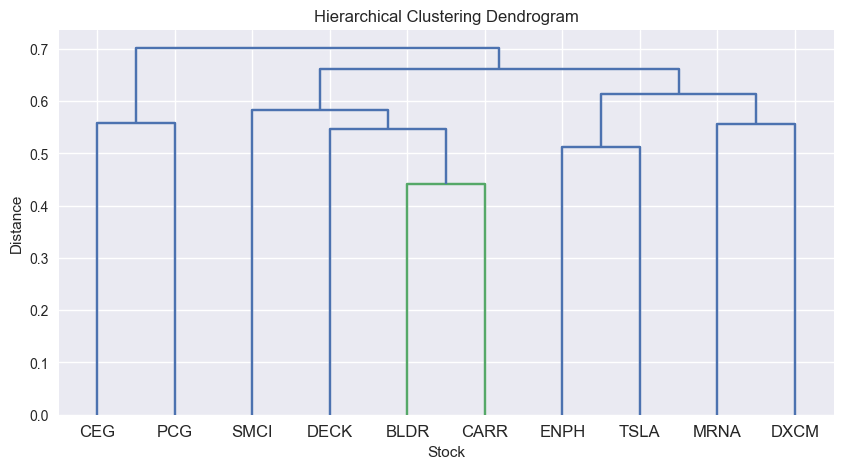

In [27]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage

# Define portfolio stocks (make sure this is correct and contains only your stock symbols)
portfolio_stocks = df_portfolio['Symbol'].tolist()
print("Portfolio stocks:", portfolio_stocks)

# Calculate daily returns for only the stocks in the portfolio
returns = stock_data[portfolio_stocks].pct_change().dropna()

# Calculate the covariance matrix and then the correlation matrix
cov_matrix = returns.cov()
corr_matrix = returns.corr()

# Convert correlation matrix to distance matrix
distance_matrix = np.sqrt((1 - corr_matrix) / 2)

# Convert the full distance matrix to a condensed distance matrix
condensed_distance_matrix = squareform(distance_matrix)

# Perform hierarchical clustering
Z = linkage(condensed_distance_matrix, 'ward')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendrogram(Z, labels=portfolio_stocks)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Stock')
plt.ylabel('Distance')
plt.show()

In [29]:
from scipy.cluster.hierarchy import leaves_list

# Get the order of assets based on the hierarchical tree
sorted_indices = leaves_list(Z)

# Reorder portfolio stocks based on sorted indices
sorted_assets = [portfolio_stocks[i] for i in sorted_indices]

# Print sorted assets
print("Sorted Assets:", sorted_assets)

Sorted Assets: ['CEG', 'PCG', 'SMCI', 'DECK', 'BLDR', 'CARR', 'ENPH', 'TSLA', 'MRNA', 'DXCM']


In [30]:
# Recursive Bisection for Weight Allocation (Maximizing Sharpe Ratio)
# The recursive bisection process involves dividing the portfolio into two halves at each step, optimizing the split point to maximize the Sharpe ratio
# (return per unit of risk) by calculating the Sharpe ratio for different possible splits, and choosing the split that maximizes this ratio and
# finally adjusting the weights based on the volatility and return of each sub-cluster.

from scipy.optimize import minimize_scalar

def sharpe_ratio(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = portfolio_return / portfolio_vol
    return -sharpe_ratio  # Minimize the negative Sharpe ratio for maximization

def find_optimal_split(cov_matrix, returns, assets_order):
    n = len(assets_order)
    if n <= 1:
        return 0, 1  # Base case: no split possible

    def objective(split_point):
        split_point = int(split_point)
        weights_left = np.repeat(1 / split_point, split_point)
        weights_right = np.repeat(1 / (n - split_point), n - split_point)
        weights = np.concatenate([weights_left, weights_right])
        return sharpe_ratio(weights, returns[assets_order], cov_matrix.loc[assets_order, assets_order])

    result = minimize_scalar(objective, bounds=(1, n-1), method='bounded')
    optimal_split_point = int(result.x)
    return optimal_split_point, -result.fun  # Return max Sharpe ratio

def recursive_bisection(cov_matrix, returns, assets_order):
    optimal_split_point, max_sharpe = find_optimal_split(cov_matrix, returns, assets_order)
    if optimal_split_point == 0:
        return {assets_order[0]: 1.0}

    # Recursive calls for each optimal half
    left_assets = assets_order[:optimal_split_point]
    right_assets = assets_order[optimal_split_point:]

    left_weights = recursive_bisection(cov_matrix, returns, left_assets)
    right_weights = recursive_bisection(cov_matrix, returns, right_assets)

    # Combine and normalize weights
    total_weights = {}
    total_weights.update(left_weights)
    total_weights.update(right_weights)
    total_weight = sum(total_weights.values())
    normalized_weights = {k: v / total_weight for k, v in total_weights.items()}
    return normalized_weights

# Calculate expected annual returns for stocks
expected_returns = returns.mean() * 252

# Calculate weights using refined HRP
weights = recursive_bisection(cov_matrix, expected_returns, sorted_assets)

### Calculate portfolio metrics

In [31]:
def calculate_portfolio_metrics(weights, returns, cov_matrix, risk_free_rate=0):
    # Extract the weights and corresponding returns and covariance matrix
    portfolio_weights = np.array([weights.get(ticker, 0) for ticker in returns.index])
    portfolio_returns = returns.values
    portfolio_cov_matrix = cov_matrix.loc[returns.index, returns.index].values

    # Calculate expected annual return
    expected_annual_return = np.sum(portfolio_weights * portfolio_returns)

    # Calculate annual volatility
    annual_volatility = np.sqrt(np.dot(portfolio_weights.T, np.dot(portfolio_cov_matrix, portfolio_weights)))

    # Calculate Sharpe Ratio
    sharpe_ratio = (expected_annual_return - risk_free_rate) / annual_volatility

    return expected_annual_return, annual_volatility, sharpe_ratio

# Assuming 'expected_returns' and 'cov_matrix' are already defined and contain the correct data
expected_return, volatility, sharpe = calculate_portfolio_metrics(weights, expected_returns, cov_matrix)

print("Optimized Portfolio Weights and Expected Returns for Each Stock:")
for stock in weights:
    print(f"{stock}: Weight = {weights[stock]:.4f}, Expected Annual Return = {expected_returns[stock]:.2%}")

print(f"\nPortfolio Expected Annual Return: {expected_return:.2%}")
print(f"Portfolio Annual Volatility: {volatility:.2%}")
print(f"Portfolio Sharpe Ratio: {sharpe:.4f}")

Optimized Portfolio Weights and Expected Returns for Each Stock:
CEG: Weight = 0.2500, Expected Annual Return = 61.21%
PCG: Weight = 0.2500, Expected Annual Return = 22.53%
SMCI: Weight = 0.2500, Expected Annual Return = 123.01%
DECK: Weight = 0.0625, Expected Annual Return = 46.81%
BLDR: Weight = 0.0625, Expected Annual Return = 54.13%
CARR: Weight = 0.0312, Expected Annual Return = 15.10%
ENPH: Weight = 0.0312, Expected Annual Return = 21.72%
TSLA: Weight = 0.0312, Expected Annual Return = 3.28%
MRNA: Weight = 0.0156, Expected Annual Return = -11.36%
DXCM: Weight = 0.0156, Expected Annual Return = 18.13%

Portfolio Expected Annual Return: 59.36%
Portfolio Annual Volatility: 1.95%
Portfolio Sharpe Ratio: 30.4658


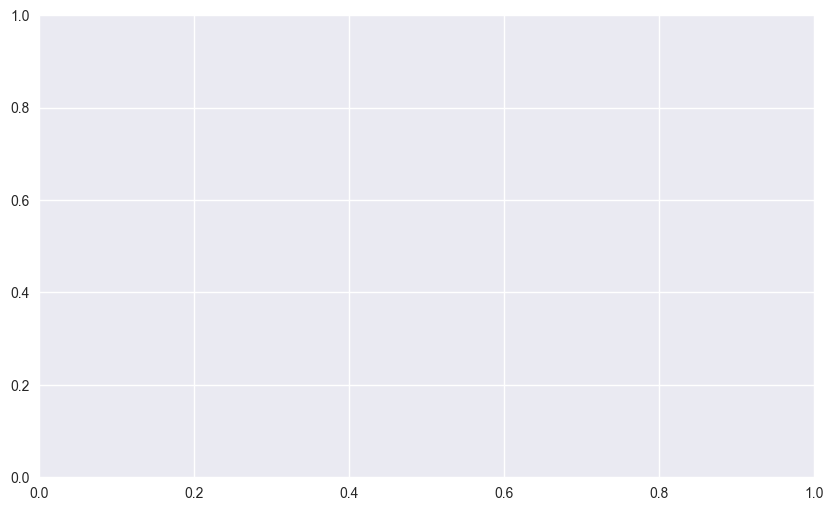

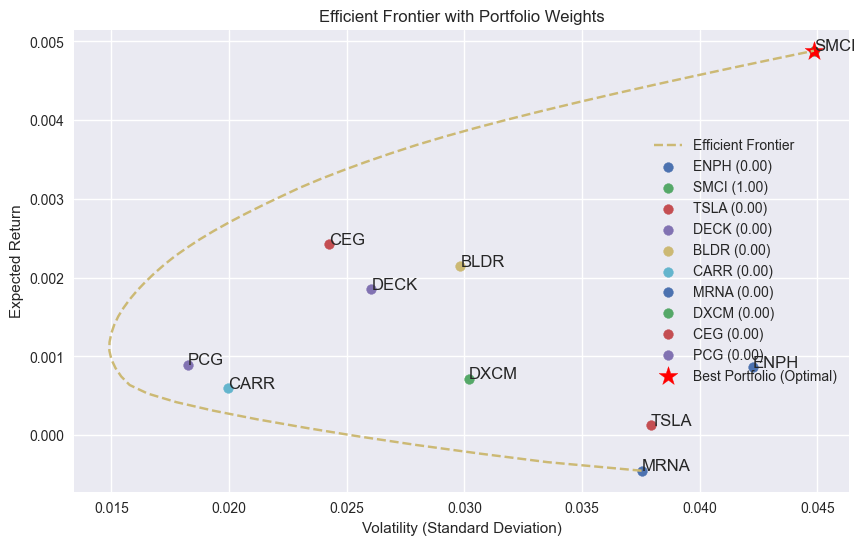

In [48]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate portfolio metrics
def calculate_portfolio_metrics(weights, returns, cov_matrix, risk_free_rate=0.01):
    portfolio_return = np.dot(returns.mean(), weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return portfolio_return, portfolio_volatility, sharpe_ratio

# Function to minimize the negative Sharpe ratio (maximize Sharpe ratio)
def maximize_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate=0.01):
    return -calculate_portfolio_metrics(weights, returns, cov_matrix, risk_free_rate)[2]

# Function to plot the Efficient Frontier and highlight the optimal portfolio
def plot_efficient_frontier(returns, cov_matrix):
    num_assets = len(returns.columns)
    initial_weights = np.array([1. / num_assets] * num_assets)
    bounds = tuple((0, 1) for asset in range(num_assets))
    cons = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# Find optimal portfolio
    optimal_result = minimize(maximize_sharpe_ratio, initial_weights, args=(returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=[cons])
    optimal_return, optimal_volatility, _ = calculate_portfolio_metrics(optimal_result.x, returns, cov_matrix)

    # Plotting the Efficient Frontier
    fig, ax = plt.subplots(figsize=(10, 6))

    # Minimize volatility for a range of returns to plot the frontier
    target_returns = np.linspace(returns.mean().min(), returns.mean().max(), 50)
    frontier_volatility = []
    
    for ret in target_returns:
        constraints = cons.copy()
        constraints['fun'] = lambda x: calculate_portfolio_metrics(x, returns, cov_matrix)[0] - ret
        result = minimize(minimize_volatility, initial_weights, args=(returns, cov_matrix), method='SLSQP', bounds=bounds, constraints=[constraints, cons])
        frontier_volatility.append(calculate_portfolio_metrics(result.x, returns, cov_matrix)[1])

    # Plotting the Efficient Frontier
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(frontier_volatility, target_returns, 'y--', label='Efficient Frontier')
    
    # Plot each stock with its weight
    for i, symbol in enumerate(returns.columns):
        vol = np.sqrt(cov_matrix.loc[symbol, symbol])
        ret = returns[symbol].mean()
        weight = optimal_result.x[i]
        ax.scatter(vol, ret, label=f"{symbol} ({weight:.2f})")
        ax.annotate(symbol, (vol, ret))

    # Highlight the optimal portfolio
    ax.scatter(optimal_volatility, optimal_return, color='red', marker='*', s=200, label='Best Portfolio (Optimal)')
    ax.set_title("Efficient Frontier with Portfolio Weights")
    ax.set_xlabel("Volatility (Standard Deviation)")
    ax.set_ylabel("Expected Return")
    ax.legend()
    plt.show()

# Call the function
plot_efficient_frontier(returns, cov_matrix)

The hierarchical risk parity optimization gave us the most promising results. While the expected annual return was not as high as the Efficient Frontier model, the volatilty was significantly lower, and the Sharpe Ratio was significantly higher. This looks like the most attractive combination to explore going forward.

## Preprocessing and Modeling

<a id='preprocessing'></a>


### 4a. Ordinary Least Squares Model

<a id='ols'></a>


In [49]:
import statsmodels.api as sm

# Assuming 'weights' is a dictionary with stock symbols as keys
# Convert weights to a DataFrame for easier handling
weights_df = pd.DataFrame(list(weights.items()), columns=['Symbol', 'Weight'])
weights_df.set_index('Symbol', inplace=True)

# Calculate historical returns and volatility
historical_returns = returns.mean() * 252  # Annualized
volatility = returns.std() * np.sqrt(252)  # Annualized

# Create a DataFrame with these metrics
metrics_df = pd.DataFrame({
    'Historical Returns': historical_returns,
    'Volatility': volatility
})

# Merge the weights with the metrics
full_data = weights_df.join(metrics_df)

# Add any additional data from df_sp500 if required, for example, MarketCap
# Ensure df_sp500 is indexed by 'Symbol' or similar adjustments are made
# full_data = full_data.join(df_sp500[['MarketCap', 'Beta']])

# Drop any rows with missing data to avoid errors in regression
full_data.dropna(inplace=True)

# Prepare data for regression
X = sm.add_constant(full_data[['Historical Returns', 'Volatility']])  # Add a constant for the intercept
y = full_data['Weight']

# Fit the regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.425
Method:                 Least Squares   F-statistic:                     4.329
Date:                Fri, 19 Apr 2024   Prob (F-statistic):             0.0597
Time:                        21:20:51   Log-Likelihood:                 12.926
No. Observations:                  10   AIC:                            -19.85
Df Residuals:                       7   BIC:                            -18.94
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.1489      0

C:\Users\money\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


Overall the results from this model look promising, with the caveat that many of the results are likely impacted by the small sample size of the portfolio. Below is a summary of the statistics:<br>
Regression Summary Analysis<br>
Model Fi<br>t
R-squared (0.553): This suggests that about 55.3% of the variability in portfolio weights is explained by the model. This is a moderate level of explanation, indicating that the model captures a significant portion of the data's variability but still leaves room for unexplained factor<br>s.
Adjusted R-squared (0.425): This adjusted metric accounts for the number of predictors and the sample size. It's lower than the R-squared, reflecting the fact that adding variables isn't free and comes at the cost of potentially overfitting. The adjustment is especially important given the small sample si<br>ze.
Statistical Signific<br>ance
F-statistic (4.329) and Prob (F-statistic) (0.0597): The F-statistic tests the null hypothesis that all regression coefficients are zero (i.e., the model has no explanatory power). A p-value of about 0.06 is just above the traditional threshold of 0.05, suggesting that the model is on the cusp of being statistically significant. This result indicates that there may be some relationship between the predictors and the response variable, but it's not strong enough to be definitive at the 0.05 l<br>evel.
Coeffi<br>cients
Intercept (0.1489; p=0.153): The coefficient for the intercept is not statistically significant, indicating uncertainty about the baseline level of weights when the predictors ar<br>e zero.
Historical Returns (0.2026; p=0.025): This coefficient is significant at the conventional 0.05 level, suggesting that higher historical returns are associated with higher portfolio weights. The positive relationship indicates that as historical returns increase by 1%, the weight in the portfolio increases by about <br>0.2026%.
Volatility (-0.2445; p=0.228): The negative coefficient for volatility, though not statistically significant, suggests a potential trend where higher volatility might lead to lower weights in the portfolio. However, more data or refined analysis might be needed to confirm this rela<br>tionship.
D<br>iagnostics
Durbin-Watson (0.864): This statistic tests for autocorrelation in the residuals; values close to 2 suggest no autocorrelation. A value of 0.864 indicates positive autocorrelation, which might suggest issues with the model assumptions or the data sampli<br>ng process.
Omnibus/Prob(Omnibus), Jarque-Bera/Prob(JB): These tests check the normality of residuals. The results indicate that residuals are roughly normally distributed, as the p-values are large, suggesting no violation of the normality assumption.in this case.

## 4b. Expanded Sampling

In [54]:
#Creating 100 random portfolios w/ HRP to expand analysis

import numpy as np

# Assuming 'clean_stock_data' is your DataFrame with all stock prices
all_stocks = clean_stock_data.columns.tolist()
num_portfolios = 100
portfolio_size = 10  # Adjust the size as needed

random_portfolios = {
    i: np.random.choice(all_stocks, size=portfolio_size, replace=False)
    for i in range(num_portfolios)
}

In [55]:
portfolio_results = {}
for i, stocks in random_portfolios.items():
    # Filter the data for the selected stocks
    data = clean_stock_data[stocks]
    daily_returns = data.pct_change().dropna()

    # Calculate covariance matrix and expected returns
    cov_matrix = daily_returns.cov() * 252  # Annualized
    expected_returns = daily_returns.mean() * 252

    # Apply HRP Optimization (assuming you have an HRP function ready)
    weights = your_hrp_function(cov_matrix, expected_returns)
    weights_array = np.array(list(weights.values()))

    # Calculate portfolio metrics
    portfolio_return = np.dot(weights_array, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights_array.T, np.dot(cov_matrix, weights_array)))
    sharpe_ratio = portfolio_return / portfolio_volatility

    # Store results
    portfolio_results[i] = {
        'Weights': weights,
        'Return': portfolio_return,
        'Volatility': portfolio_volatility,
        'Sharpe Ratio': sharpe_ratio
    }

NameError: name 'your_hrp_function' is not defined

In [53]:
# Print out to inspect if they really match
print(expected_returns.index)
print(list(weights.keys()))

Index(['KHC', 'VZ', 'NEE', 'WRB', 'META', 'NTAP', 'PPL', 'APD', 'NFLX', 'BIO'], dtype='object', name='Ticker')
['GRMN', 'SNPS', 'EBAY', 'AZO', 'KVUE', 'EVRG', 'TXT', 'CE', 'NOC', 'HST']


In [52]:
portfolio_metrics = {}

for portfolio_id, weights in hrp_weights.items():
    weights_array = np.array(list(weights.values()))
    cov_matrix = clean_stock_data[list(weights.keys())].pct_change().dropna().cov() * 252
    portfolio_return = np.dot(weights_array, expected_returns[list(weights.keys())])
    portfolio_volatility = np.sqrt(np.dot(weights_array.T, np.dot(cov_matrix, weights_array)))
    sharpe_ratio = portfolio_return / portfolio_volatility

    portfolio_metrics[portfolio_id] = {
        'Return': portfolio_return,
        'Volatility': portfolio_volatility,
        'Sharpe Ratio': sharpe_ratio
    }

KeyError: "None of [Index(['GRMN', 'SNPS', 'EBAY', 'AZO', 'KVUE', 'EVRG', 'TXT', 'CE', 'NOC',\n       'HST'],\n      dtype='object', name='Ticker')] are in the [index]"